# DICOM Files and Medical Image Rendering

## Introduction

In this notebook we will discuss what is a DICOM file and how to work with them. We will also discuss basics on medical image rendering. We will cover the following points:

* What is a DICOM file, how to open, read and use the information in the file
* Image Rendering and the effect of reducing the encoding bits on the image

## DICOM

DICOM is the most popular standard used in medicine for image exchange. The name is derived from **D**igital **I**maging and **CO**mmunication in **M**edicine. It allows to have medical information in the images as a standard file that is independent from the manufacturer. This means that it is possible to have images from MR scanners made by a GE system and display it in a picture archive system (PACS) from Agfa without any loss or without need of any proprietary information. It also allows opening the image in MATLAB, Python or any language without need to know how GE formatted the image file.

We will open here a DICOM image and see some of the information that is stored in the header of the image. 

Python provides some tools for DICOM image opening in the package PyDICOM.

The current Azure release will likely be missing this package, so we will install it every time using a command line. For this, we will use a command line as follows:

## Opening DICOM for metadata

We can now use the package to open a DICOM file. 

In [1]:
!pip install pydicom

    100% |████████████████████████████████| 7.0MB 105kB/s ta 0:00:011


In [2]:
# As usual we will have the magic command for figures inline, but you can use interactive nbagg if you prefer
%matplotlib inline

# And we will start by importing the numerical and ploting packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# As well as the DICOM package
import pydicom

# Get file
RefDs = pydicom.read_file('../library/IM_0028.dcm')

# Let's print all the Metadata here
print(RefDs)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']
(0008, 0012) Instance Creation Date              DA: '20120101'
(0008, 0013) Instance Creation Time              TM: '122531'
(0008, 0014) Instance Creator UID                UI: 1.3.46.670589.11.2501708638.4193405253.2729028880.3304384116
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.46.670589.11.3397498352.605445821.304410668.1378834227
(0008, 0020) Study Date                          DA: '20110101'
(0008, 0021) Series Date                         DA: '20110101'
(0008, 0022) Acquisition Date                    DA: '20110101'
(0008, 0023) Content Date                        DA: '20110101'
(0008, 0030) Study Time                          TM: '133916'
(0008, 0031) Series Time                         TM: '135504.20'
(0008, 0032) Acquisition Time    

You can browse through that Metadata and see all the information about this image. There is a lot of information but we can already easily find out much about this image without having to know much about the specific acquisition details. It is clear  this is a **Magnetic Resonance Image** made with a **Philips scanner**.

### Activity 1 - From browsing the metadata, answer the following questions and write your answer in a different color in this markdown cell. You should include the field information [i.e. (####, ####)]

* What is the size in pixels of the image? 
<font color="red"> Answer: (0028, 0010) Rows: 512, (0028, 0011) Cols: 512 </font>

* There are two fields with information about bits used for the image, find them
<font color="blue"> Answer: (0028, 0100) Bits Allocated: 16, (0028, 0101) Bits Stored: 12 </font>

* What is the difference between those number of bits? 
<font color="green"> Answer: The difference between these bits is the memory allocated for the image vs. what was used. 
    This is over allocation. </font>

* What is the full name of the vendor and the model of the scanner used to do this image?
<font color="purple"> Answer: (0008, 0070) Manufacturer: Philips Medical Systems, (0008, 1090) Model: Acheiva </font>

* When was this image taken? Is this consistent with the file date? Why would you need this field embedded in the file?
<font color="grey"> Answer: (0008, 0022) Acquisition date: 2011/01/01. The instance creation date is: 2012/01/01. 
The reason this field is embedded in the file is because the date of filing and date of image acquisition could be different. </font>
    
* Which body part was the focus of the study? 
<font color="green"> Answer: (0018, 0015) The body part examined was the liver. </font>


* Was the subject a man or a woman?
<font color="blue"> Answer: (0010, 0040) The patients sex is female  </font>


* Can you find the patient name in this particular example? Why?
<font color="red"> Answer: The patient name is redacted from the metadata as it is confidential. </font>


## Using DICOM metadata
Let's use code to access the metadata information simply by using the variable

In [3]:
from datetime import datetime   #used to format dates

print('The image is '+str(RefDs.Rows)+'x'+str(RefDs.Columns)+' pixels')
print('The image was encoded with '+str(RefDs.BitsStored)+' bits ')
print('The manufacturer is '+str(RefDs.Manufacturer)+' and the model is '+str(RefDs.ManufacturerModelName))
d=datetime.strptime(RefDs.AcquisitionDate,'%Y%m%d')
print('The image was made on '+str(d.date()))
print('The anatomy imaged is '+str(RefDs.BodyPartExamined))
if RefDs.PatientSex=='F':
    print('The patient imaged is Female')
else:
    print('The patient imaged is Male')
if RefDs.PatientName=='':
    print('The patient\'s name is unkown')
else:
    print('The patient\'s name is '+str(RefDs.PatientsName))

The image is 512x512 pixels
The image was encoded with 12 bits 
The manufacturer is Philips Medical Systems and the model is Achieva
The image was made on 2011-01-01
The anatomy imaged is LIVER
The patient imaged is Female
The patient's name is unkown


## Image Rendering

Image rendering is related to all and any of the techniques that are used to show an image to the user. This may require some conditioning of the image such as enhancing and restoring the image after noise removal or simply adapting the visualization of the image to the display that is available (for instance, we may require to change and smooth the image to make use of all the dynamics of a particular screen, or use a logarithmic transform on the image so the user can see details just as we did in the Fourier notebook before for the spatial spectrum).

Let's now then render the image from the information in the DICOM file. First, we need to dimension an array with all the pixels in the image. Then, we can load the information from the file and then show the image.

[0, 511, 0, 511]

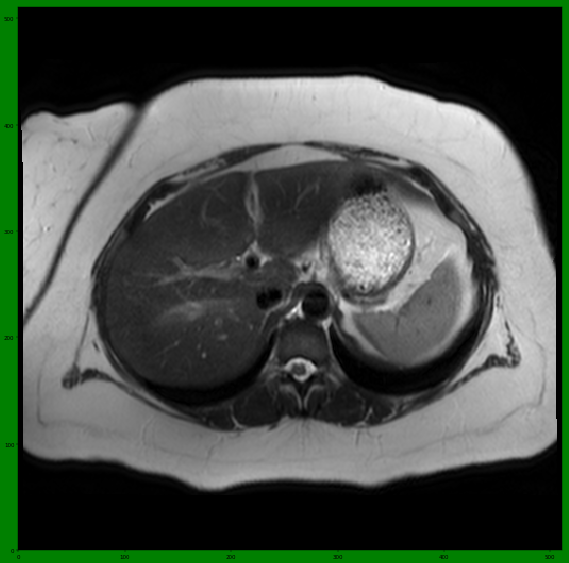

In [4]:
# To obtain the dimensions of the array to store the image we will use the metadata
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))

# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Finally we had already read the file and we have the image information in the pixel_array (final field)
ArrayDicom[:,:]=RefDs.pixel_array

# Some rendering tools here to set the size of that image to a specific value dpi and equal axis or square image as well
# as work with grayscale
fig=plt.figure(figsize=(18, 18), dpi= 40, facecolor='g', edgecolor='r')
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale

# We could directly show the image using imshow as in the last notebook, but we can use a more traditional took using 
# colormesh (plotting 2D) 
# I chose colormesh since imshow already introduces default rendering that would not require aspect or grayscale

# Colormesh will require a horizontal and vertical axes
Rows=np.arange(RefDs.Rows)
Columns=np.arange(RefDs.Columns)

# This is the actual rendering
plt.pcolormesh(Rows, Columns, np.flipud(ArrayDicom[:, :]))

# And definition of the axes values
plt.axis([Rows.min(),Rows.max(),Columns.min(),Columns.max()])

### Activity 2 - Change in the code values for the rendering (size of the image, dpi, frame color). Are any of those impacting your ability to interpret the image?
<font color= "red"> Answer: Changing the size (for example by changing figsize) of the image will impact how well you can see the image on the screen (obviously). Also, removing the line that sets the image to be a square will affect the dimensions of the image if different dimensions are applied, this can result in one misinterpreting the relative sizing of the liver in the image. One can also change the dpi to change the images overall resolution. Changing the facecolor may also help one see the overall size of the image as opposed to when it is simply white. </font>

### Activity 3 - When rendering the image the code flipped the array, add below a cell that renders the image without that flip but with the same rendering as before. Answer here why did we need that flip? Can you infer where is the anterior/posterior in this patient? What about the left/right side? (Tip: check the metadata for information that can help you orient the patient)


<font color= "red"> Answer: The image flip pretty much just makes the image easier to read and understand. From the metadata we can see that the patient is head first supine, so the image had to be rotated 90 degrees for viewing. 
(0018, 5100) Patient Position CS: 'HFS' which means that the patient is head first supine. Therefore the posterior of the patient is at the top of the image and the anterior is at the bottom of the image. </font> 

[0, 511, 0, 511]

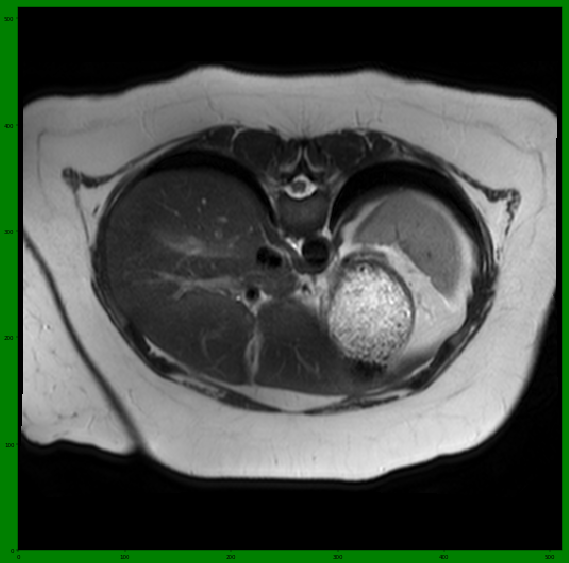

In [5]:
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))

# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Finally we had already read the file and we have the image information in the pixel_array (final field)
ArrayDicom[:,:]=RefDs.pixel_array

# Some rendering tools here to set the size of that image to a specific value dpi and equal axis or square image as well
# as work with grayscale
fig=plt.figure(figsize=(18, 18), dpi= 40, facecolor='g', edgecolor='r')
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale

# We could directly show the image using imshow as in the last notebook, but we can use a more traditional took using 
# colormesh (plotting 2D) 
# I chose colormesh since imshow already introduces default rendering that would not require aspect or grayscale

# Colormesh will require a horizontal and vertical axes
Rows=np.arange(RefDs.Rows)
Columns=np.arange(RefDs.Columns)

# This is the actual rendering
plt.pcolormesh(Rows, Columns, np.flipud(np.flipud(ArrayDicom[:, :])))

# And definition of the axes values
plt.axis([Rows.min(),Rows.max(),Columns.min(),Columns.max()])

## Image Encoding

One of the main situations we encounter when rendering an image is a difference in the amount of bit encoding that was used for an image. For instance, we may have an image that was encoded by an MRI or a CT using 12 bits but it was later converted into a JPG or PNG file and necessarily lost some information because these techniques will use only 8 bits per pixel.

We will study here the effect that encoding can have in the rendering of an image by presenting the changes on the observed image at different bit encodings. 

Text(0.5, 1.0, 'Encoded at 3 bits Max=7')

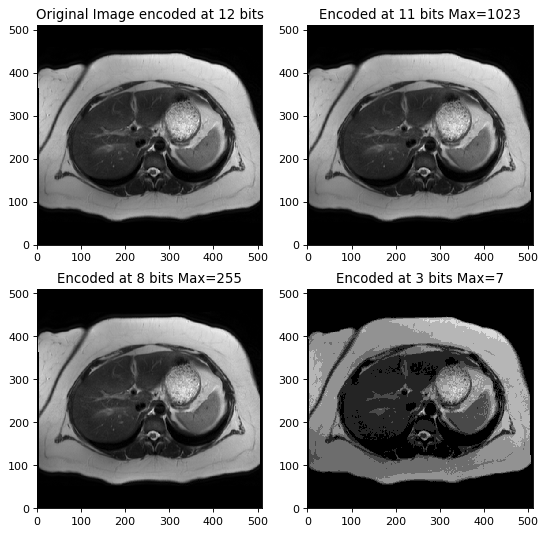

In [6]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale

# To encode an image we will first normalize it and then multiply by the maximum value allowed by the encoding scheme
# Ensuring that we convert into float
NormIm=1.0*ArrayDicom
NormIm=NormIm/np.max(ArrayDicom)
Im=NormIm*(pow(2,12)-1)  #original encoding at 12 bits
Im=Im.astype(int)
Jm=NormIm*(pow(2,10)-1)  #encoding at 10 bits
Jm=Jm.astype(int)
Km=NormIm*(pow(2,8)-1)  #encoding at 8 bits
Km=Km.astype(int)
Lm=NormIm*(pow(2,3)-1)  #encoding at 3 bits
Lm=Lm.astype(int)

bp=plt.subplot(221)
plt.pcolormesh(Rows, Columns, np.flipud(Im[:, :]))
plt.title('Original Image encoded at 12 bits')
plt.subplot(222)
plt.pcolormesh(Rows, Columns, np.flipud(Jm[:, :]))
plt.title('Encoded at 11 bits Max='+str(np.max(Jm)))
plt.subplot(223)
plt.pcolormesh(Rows, Columns, np.flipud(Km[:, :]))
plt.title('Encoded at 8 bits Max='+str(np.max(Km)))
plt.subplot(224)
plt.pcolormesh(Rows, Columns, np.flipud(Lm[:, :]))
plt.title('Encoded at 3 bits Max='+str(np.max(Lm)))


We can observe that we can reduce the encoding to 8 bits without much contrast loss as it would likely happen when converting into a PNG format. The main reason for the successful reduction in encoding bits without contrast loss is that the image is mostly dark and the dynamic in 8 bits is enough for the contrast to remain. However, it should be possible to reduce to 8 bits with even lower contrast loss if we use image enhancement techniques. 

In the histogram of this original image we can clearly observe that most of the information is in the black with a very high number of pixels being dark (surrounding air).

(0, 4096)

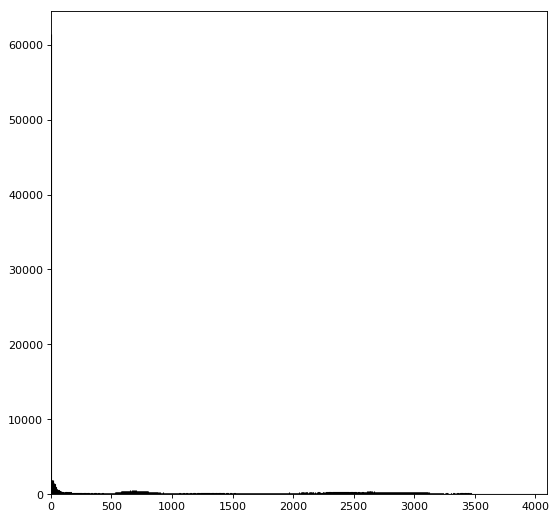

In [7]:
# This uses numpy to generate a histogram
hist,bins = np.histogram(Im.flatten(),4096,[0,4096])

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')

# And we plot the histogram here for the original 12 bit image
plt.hist(Im.flatten(), 4096, [0,4096], fc='k', ec='k')
plt.xlim([0,4096])

### Activity 4 - Obtain the histograms for all the encodings below

(0, 250)

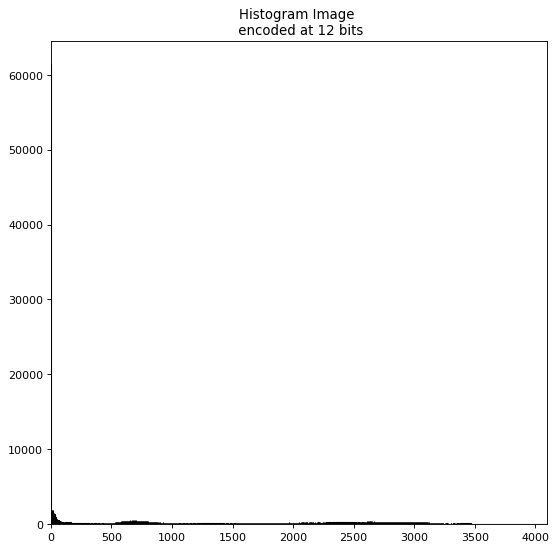

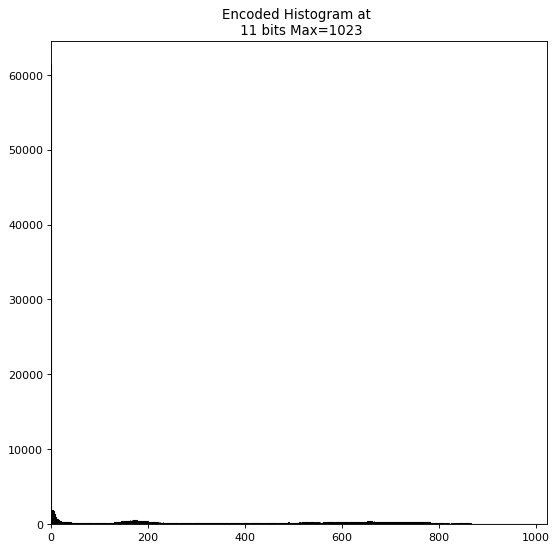

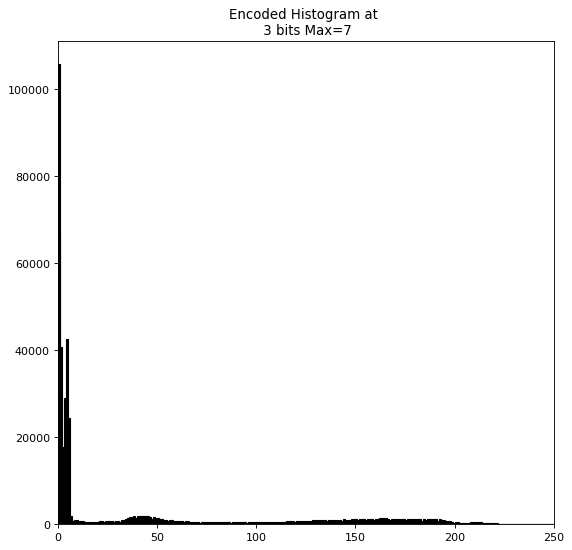

In [10]:
#code to obtain histograms for all encodings
hist,bins = np.histogram(Im.flatten(),4096,[0,4096])

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.hist(Im.flatten(), 4096, [0,4096], fc='k', ec='k')
plt.title('Histogram Image \n encoded at 12 bits')
plt.xlim([0,4096])

hist,bins = np.histogram(Jm.flatten(),4096,[0,4096])
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.hist(Jm.flatten(), 1023, [0,1023], fc='k', ec='k')
plt.title('Encoded Histogram at \n 11 bits Max='+str(np.max(Jm)))
plt.xlim([0,1023])

hist,bins = np.histogram(Km.flatten(),250,[0,250])
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.hist(Km.flatten(), 250, [0,250], fc='k', ec='k')
plt.title('Encoded Histogram at \n 8 bits Max='+str(np.max(Km)))
plt.xlim([0,250])

hist,bins = np.histogram(Lm.flatten(),4096,[0,4096])
plt.hist(Lm.flatten(), 250, [0, 250], fc='k', ec='k')
plt.title('Encoded Histogram at \n 3 bits Max='+str(np.max(Lm)))
plt.xlim([0,250])



(0, 250)

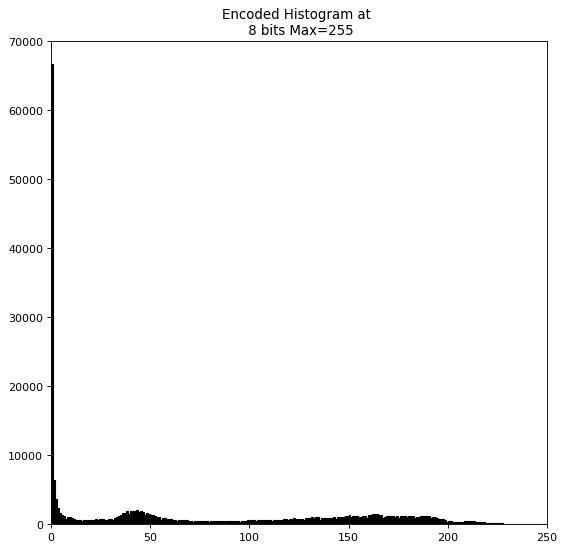

In [9]:
#here is the 8 bit encoded histogram, for some reason it would not print with the others above!
hist,bins = np.histogram(Km.flatten(),250,[0,250])
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.hist(Km.flatten(), 250, [0,250], fc='k', ec='k')
plt.title('Encoded Histogram at \n 8 bits Max='+str(np.max(Km)))
plt.xlim([0,250])

We could get better contrast by just doing a histogram equalization as it will be done below. In this case, we are "stretching" the histogram so we can better use the dynamics. 

### Activity 5 - Add comments to the code below explaining where and how this histogram equalization is done. Modify the code cell to also do this equalization for the 8-bit encoded image and plot all four images. Make observations on the images.

<font color= "red">As can be seen from the images that are now equalized the contrast has increased dramatically making structures in the image much easier to identify. The 12 bit and 8 bit images look almost identical however their histograms are quite different as the 8 bit image has a less of a conentration of darker pixels. </font>

(array([6.1423e+04, 0.0000e+00, 0.0000e+00, ..., 6.3000e+01, 4.9000e+01,
        5.1000e+01]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.094e+03, 4.095e+03,
        4.096e+03]),
 <a list of 4096 Patch objects>)

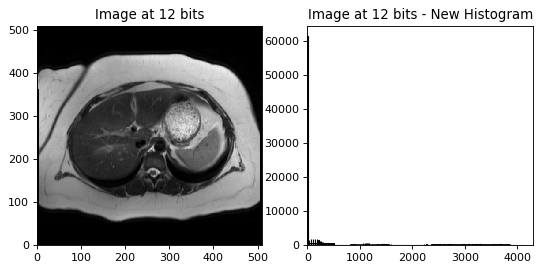

In [9]:
hist,bins = np.histogram(Im.flatten(),4096,[0,4096]) #here the matrix is flattened to one dimension
cdf = hist.cumsum() #returns the cumulative sum of the elments        
 
cdf = (cdf - cdf.min())*4096/(cdf.max()-cdf.min())         
cdf = np.ma.filled(cdf,0).astype('uint16')                

Im2 = cdf[Im]                              

hist,bins = np.histogram(Im2.flatten(),4096,[0,4096])

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')

plt.subplot(221)
plt.pcolormesh(Rows, Columns, np.flipud(Im[:, :]))
plt.title('Image at 12 bits')
plt.subplot(222)
plt.pcolormesh(Rows, Columns, np.flipud(Im2[:, :]))
plt.title('Image at 12 bits - New Histogram')

# And we plot the histogram here for the original 12 bit image
plt.hist(Im2.flatten(), 4096, [0,4096], fc='k', ec='k')

(array([6.6619e+04, 0.0000e+00, 0.0000e+00, ..., 1.0000e+02, 4.6000e+01,
        5.4000e+01]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.094e+03, 4.095e+03,
        4.096e+03]),
 <a list of 4096 Patch objects>)

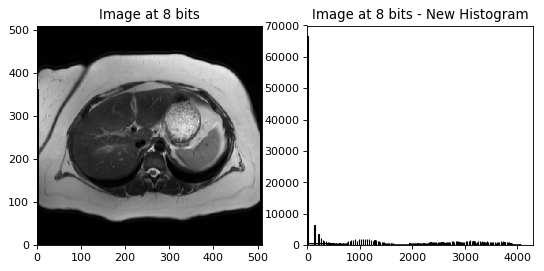

In [10]:
#activity 5 
#doing same as above with 8 bit image:
hist,bins = np.histogram(Km.flatten(),4096,[0,4096]) #here the matrix is flattened to one dimension
cdf = hist.cumsum() #returns the cumulative sum of the elments        
 
cdf = (cdf - cdf.min())*4096/(cdf.max()-cdf.min())         
cdf = np.ma.filled(cdf,0).astype('uint16')                

Km2 = cdf[Km]                              

hist,bins = np.histogram(Km2.flatten(),4096,[0,4096])

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')

plt.subplot(221)
plt.pcolormesh(Rows, Columns, np.flipud(Km[:, :]))
plt.title('Image at 8 bits')
plt.subplot(222)
plt.pcolormesh(Rows, Columns, np.flipud(Km2[:, :]))
plt.title('Image at 8 bits - New Histogram')

# And we plot the histogram here for the original 12 bit image
plt.hist(Km2.flatten(), 4096, [0,4096], fc='k', ec='k')

## Challenge \# 4 - Histogram Equalization

Add code, figures and a markdown with equation to explain what is done with the histogram equalization that was briefly introduced. 


## Challenge \# 5 - Interactive plot

Make an interactive rendering that provides a sliding tool to define the bits for encoding (Tip: investigate the *interact* in *ipwidgets*)

By using your interactive tools answer:
* What seems to be the minimum amount of bits to use if the contrast should be kept for the liver?
<font color=green> 5 bits </font>
* What is the organ within the abdomen for which you loose contrast first?
<font color=green> Liver </font>

## Summary

In this example we:

* Analyzed the impact of reducing the encoding bits in an image on the rendering to the user
* Investigated a histogram equalization technique to better use the dynamic provided by the encoding bits

Comments and corrections welcome!

References
---------------

* Tinku Acharya and Ajoy K. Ray, *Image Processing - Principles and Applications*. Wiley InterScience, 2006.